In [1]:
_ = """
Desciption
- hnm products
- Not use of pytorch_forecasting
- year, month, day, dayofweek as positional embedding feature
"""

# Configurations

### Import

In [2]:
import os
import joblib
import random
from IPython.display import clear_output

import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tslearn.utils import to_time_series_dataset

import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel

from transformers import ViTModel, ViTConfig
import matplotlib.cm as cm
import cv2

device = torch.device("cuda:1")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [3]:
# Sampling parameter
n_smaples = None

# Data parameter
random_state = 0
pred_len = 30
batch_size = 32
valid_start_date = "2020-06-01"

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 256; d_ff = 512; d_ff = 1024
dropout = 0.3; dropout = 0.3
num_layers = 4; num_layers = 6

# Seed set
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

# Data

### Read

In [4]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_train_raw = df_trans[df_trans["t_dat"] < valid_start_date]
df_valid_raw = df_trans[df_trans["t_dat"] >= valid_start_date]

### Preprocess

In [5]:
def preprocess(data):
    data = data.copy()
    data = data.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("customer_id","size"), price=("price","mean"))

    # Make date positions
    data["year"] = data["t_dat"].dt.year
    data["month"] = data["t_dat"].dt.month - 1
    data["week"] = data["t_dat"].dt.isocalendar().week - 1
    data["day"] = data["t_dat"].dt.day -1
    data["dayofweek"] = data["t_dat"].dt.dayofweek
    
    # Aggregate with list
    data = data.groupby(["article_id"], as_index=False)[["sales", "price", "year", "month", "week", "day", "dayofweek"]].agg(lambda x: list(x))
    data["size"] = data["sales"].str.len()

    # Read article info
    df_article = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_article = df_article[["article_id"] + [col for col in df_article.columns if "name" in col]]

    # Merge two datasets
    df_raw = pd.merge(data, df_article, on="article_id")
    print(f"Original: {df_raw.shape}")

    # Filter valid length
    df_prep = df_raw.copy()
    df_prep = df_prep[df_prep["size"] > pred_len]
    print(f"Valid sized: {df_prep.shape}")

    # Sampling
    if n_smaples:
        samples = df_prep["article_id"].unique()
        df_prep = df_prep[df_prep["article_id"].isin(samples[:n_smaples])]
        print(f"{min(n_smaples, df_prep['article_id'].nunique())} sampled: {df_prep.shape}")

    # Encode imgpath
    encoder = LabelEncoder()
    df_prep["img_path"] = df_prep["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg') # Generate image path
    df_prep["is_valid"] = df_prep["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    df_prep = df_prep[df_prep["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image
    print(f"Valid imaged:", df_prep.shape)

    # Expand date

    return df_prep

In [6]:
df_train_prep = preprocess(df_train_raw); print("_"*100)
df_valid_prep = preprocess(df_valid_raw)

# Save
df_train_prep.to_parquet("df_train_prep.parquet")
df_valid_prep.to_parquet("df_valid_prep.parquet")

Original: (93804, 21)
Valid sized: (50298, 21)
Valid imaged: (50142, 22)
____________________________________________________________________________________________________
Original: (45975, 21)
Valid sized: (13728, 21)
Valid imaged: (13708, 22)


### Dataset

In [4]:
exclude_li = ["Vest top", "Bra", "Underwear Tights", "Leggings/Tights", "Hair clip", "Umbrella", "Bodysuit", "Hair string", "Socks", "Unknown", "Pyjama jumpsuit/playsuit", "Sleep Bag"
, "Belt", "Underwear bottom", "Kids Underwear top", "Pyjama set", "Sneakers", "Cap/peaked", "Earring", "Swimwear bottom", "Bikini top", "Robe", "Other accessories", "Slippers",
"Night gown", "Alice band", "Straw hat", "Ballerinas", "Tie", "Necklace", "Pyjama bottom", "Felt hat", "Bag", "Bracelet", "Other shoe", "Watch", "Hat/brim", "Underwear body",
"Swimwear set", "Flat shoe", "Ring", "Long John", "Braces", "Fine cosmetics", "Nipple covers", "Hair ties", "Bra extender", "Pumps", "Underdress", "Garment Set", "Wedge",
"Wallet", "Outdoor overall", "Hairband", "Underwear set", "Soft Toys", "Tote bag", "Waterbottle", "Bootie", "Weekend/Gym bag", "Underwear corset", "Giftbox", "Backpack", "Earrings",
"Bucket hat", "Flat shoes", "Leg warmers", "Heels", "Shoulder bag", "Headband", "Cap", "Keychain", "Dog Wear", "Side table"] 

In [5]:
df_train_prep = pd.read_parquet("df_train_prep.parquet")
df_valid_prep = pd.read_parquet("df_valid_prep.parquet")


df_train_prep = df_train_prep[~df_train_prep["product_type_name"].isin(exclude_li)]
df_valid_prep = df_valid_prep[~df_valid_prep["product_type_name"].isin(exclude_li)]

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.sales = data["sales"].values
        self.img = data["img_path"].values
        self.year = data["year"].values
        self.month = data["month"].values
        self.week = data["week"].values
        self.day = data["day"].values
        self.dayofweek = data["dayofweek"].values
    
    def __getitem__(self, idx):
        sales_raw = self.sales[idx]
        
        # Scaling
        # scaler = MinMaxScaler()
        # sales_raw = scaler.fit_transform(sales_raw.reshape(-1,1)).reshape(-1) + 1
        sales_raw = np.log1p(sales_raw)

        # Process features
        sales = sales_raw[:-pred_len]
        y = sales_raw[-pred_len:]

        img = Image.open(self.img[idx]).convert("RGB")
        img_tensor = self.transform(img).numpy()

        year = self.year[idx][:-pred_len]
        month = self.month[idx][:-pred_len]
        week = self.week[idx][:-pred_len]
        day = self.day[idx][:-pred_len]
        dayofweek = self.dayofweek[idx][:-pred_len]        

        return sales, img, img_tensor, year, month, week, day, dayofweek, y

    def __len__(self):
        return self.img.shape[0]

train_dataset = Dataset(df_train_prep)
valid_dataset = Dataset(df_valid_prep)

def func(data):
    sales = np.nan_to_num(to_time_series_dataset([sales_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()

    img = ([img_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])
    img_tensor = np.array([img_tensor_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])

    year = np.nan_to_num(to_time_series_dataset([year_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    month = np.nan_to_num(to_time_series_dataset([month_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    week = np.nan_to_num(to_time_series_dataset([week_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    day = np.nan_to_num(to_time_series_dataset([day_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    dayofweek = np.nan_to_num(to_time_series_dataset([dayofweek_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    
    y = np.array([y_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])

    sales = torch.FloatTensor(sales).unsqueeze(-1)
    img_tensor = torch.FloatTensor(img_tensor)

    year = torch.FloatTensor(year).unsqueeze(-1)
    month = torch.IntTensor(month)
    week = torch.IntTensor(week)
    day = torch.IntTensor(day)
    dayofweek = torch.IntTensor(dayofweek)

    y = torch.FloatTensor(y)

    return sales, img, img_tensor, year, month, week, day, dayofweek, y

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, shuffle=True, collate_fn=func)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, collate_fn=func)

for sales, img, img_tensor, year, month, week, day, dayofweek, y in train_dataloader:
    print(sales.shape)
    print(img_tensor.shape)
    print(year.shape)
    print(month.shape)
    print(week.shape)
    print(day.shape)
    print(dayofweek.shape)
    print(y.shape)
    break

torch.Size([32, 291, 1])
torch.Size([32, 3, 224, 224])
torch.Size([32, 291, 1])
torch.Size([32, 291])
torch.Size([32, 291])
torch.Size([32, 291])
torch.Size([32, 291])
torch.Size([32, 30])


# Modeling

### Architecture

In [7]:
class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1).to(device)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask, lookahead_mask

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.year_embedder = torch.nn.Linear(1, d_model)
        self.year_activation = torch.nn.ELU()

        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)
        self.week_embedder = torch.nn.Embedding(num_embeddings=52, embedding_dim=d_model)
        self.day_embedder = torch.nn.Embedding(num_embeddings=365, embedding_dim=d_model)
        self.dayofweek_embedder = torch.nn.Embedding(num_embeddings=7, embedding_dim=d_model)

        self.linear_embedder = torch.nn.Linear(d_model*5, d_model)
        self.linear_activation = torch.nn.ELU()

        self.linear = torch.nn.Linear(d_model, d_model)

    def forward(self, year, month, week, day, dayofweek):
        year_embedding = self.year_activation(self.year_embedder(year))
        month_embedding = self.month_embedder(month)
        week_embedding = self.week_embedder(week)
        day_embedding = self.day_embedder(day)
        dayofweek_embedding = self.day_embedder(dayofweek)

        concat = torch.concat([year_embedding, month_embedding, week_embedding, day_embedding, dayofweek_embedding], dim=-1)
        embedding = self.linear_activation(self.linear_embedder(concat))
        embedding = self.linear(embedding)
        return embedding

class Encoder(torch.nn.Module):
    def __init__(self, dropout, d_model, nhead, d_ff, num_layers):
        super().__init__()
        # Positional encoding
        self.sales_dropout = torch.nn.Dropout(dropout)
        self.sales_embedder = torch.nn.Linear(1, d_model)
        self.sales_activation = torch.nn.ELU()

        # Encoding
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, sales, positional_embedding, enc_padding_mask):
        # Positional encoding
        sales_embedding = self.sales_activation(self.sales_embedder(sales))
        sales_positional_embedding = self.sales_dropout(sales_embedding + positional_embedding)

        # Encoding
        encoding = self.encoder(sales_positional_embedding, src_key_padding_mask=enc_padding_mask)
        
        return encoding

class Decoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, num_layers):
        super().__init__()
        # Image model train
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # self.img_model = ViTModel(ViTConfig())
        self.img_activation = torch.nn.ELU()
        
        # Image model embedding
        self.img_embedder = torch.nn.Linear(self.img_model.config.hidden_size, d_model)
        self.img_embedding_activation = torch.nn.ELU()

        # Decoding
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, img_tensor, encoder_output, enc_padding_mask):
        img_hidden_state, pooler_output, attn_weight = self.img_model(img_tensor, output_attentions=True).values()
        img_hidden_state = self.img_activation(img_hidden_state)
        
        img_embedding = self.img_embedding_activation(self.img_embedder(img_hidden_state))
        dec_output = self.decoder(tgt=img_embedding, memory=encoder_output, memory_key_padding_mask=enc_padding_mask)
        
        return dec_output, attn_weight

class Transformer(torch.nn.Module):
    def __init__(self, d_model, dropout, nhead, d_ff, num_layers, pred_len):
        super().__init__()
        self.enc_mask = Mask()
        self.positional_embedder = PositionalEmbedding(d_model)
        
        self.encoder = Encoder(dropout, d_model, nhead, d_ff, num_layers)
        self.decoder = Decoder(d_model, nhead, d_ff, dropout, num_layers)

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(d_model*197, d_model)
        self.elu1 = torch.nn.ELU()
        
        self.linear2 = torch.nn.Linear(d_model, pred_len)
    
    def forward(self, sales, img_tensor, year, month, week, day, dayofweek):
        enc_padding_mask, _ = self.enc_mask(sales.squeeze(-1))
        positional_embedding = self.positional_embedder(year, month, week, day, dayofweek)

        encoder_output = self.encoder(sales, positional_embedding, enc_padding_mask)
        decoder_output, attn_weight = self.decoder(img_tensor, encoder_output, enc_padding_mask)
        
        output = self.elu1(self.linear1(self.flatten(decoder_output)))
        output = self.linear2(output)
        # output = output + torch.FloatTensor([1]).to(device)
        
        return output, attn_weight

model = Transformer(d_model, dropout, nhead, d_ff, num_layers, pred_len).to(device)
# for n, data in enumerate(train_dataloader):
#     sales, img, img_tensor, year, month, week, day, dayofweek, y = data
    
#     # Train
#     pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
#     print(pred.shape)
#     break

### Train

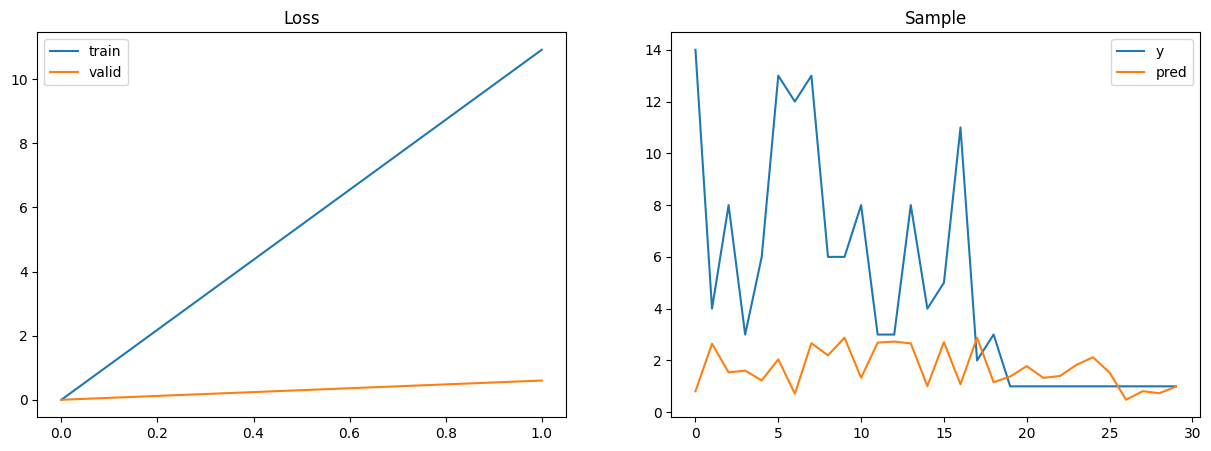

 1:87/1144 mean_train_loss: 0.2741809609261426 -- mean_val_loss: 0.60047065534834133

KeyboardInterrupt: 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

def plot_sample(y, pred):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

def train(epoch, val_loss, train_loss_li, val_loss_li):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        sales, img, img_tensor, year, month, week, day, dayofweek, y = data
        
        # Train
        optimizer.zero_grad()
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
        pred = pred.squeeze()

        # plot sample
        if n % 10 == 0: plot_sample(np.expm1(y), np.expm1(pred.detach().cpu()))
        loss = loss_fn(pred, y.to(device))
        # loss = loss_fn(torch.expm1(pred), torch.expm1(y).to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_loss}", end="")

    print()
    return mean_loss

def val(epoch):
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        sales, img, img_tensor, year, month, week, day, dayofweek, y = data
        
        # Pred
        with torch.no_grad():
            pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
            pred = pred.squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            print(f"\r {epoch}:{n}/{total_len} mean_val_loss: {mean_loss}", end="")

    print()
    return mean_loss
 
epoch = 5
train_loss_li, val_loss_li = [0], [0]
val_loss = 0

for e in range(epoch):
    train_loss = train(e, val_loss, train_loss_li, val_loss_li) # Train
    val_loss = val(e)

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    torch.save(model.state_dict(), f"model_{np.mean(train_loss)}_{np.mean(val_loss)}.pth")

In [9]:
torch.save(model.state_dict(), f"model_ref.pth")

In [13]:
def get_attention_map(img, att_mat, get_mask=False):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map, loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 5))
    ax1.set_title('Original')
    ax2.set_title(loss)
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map, cmap = cm.gray)

In [16]:
from transformers import AutoImageProcessor, SwinModel, SwinForImageClassification, ViTModel, ViTForImageClassification
import matplotlib.cm as cm
from gradcam import GradCAM
from gradcam.utils import visualize_cam
import cv2

# model.eval()
data = next(iter(valid_dataloader))

for data in valid_dataloader:
    sales, img, img_tensor, year, month, week, day, dayofweek, y = data

    for idx in range(len(data)):
        sales_ = sales[idx:idx+1]
        img_ = img[idx]
        img_tensor_ = img_tensor[idx:idx+1]
        year_ = year[idx:idx+1]
        month_ = month[idx:idx+1]
        week_ = week[idx:idx+1]
        day_ = day[idx:idx+1]
        dayofweek_ = dayofweek[idx:idx+1]
        y_ = y[idx:idx+1]

        with torch.no_grad():
            pred, attn_weight = model(sales_.to(device), img_tensor_.to(device), year_.to(device), month_.to(device), week_.to(device), day_.to(device), dayofweek_.to(device))
            loss = loss_fn(pred, y.to(device)).item()
        res = get_attention_map(img_, tuple(i.detach().cpu() for i in attn_weight), get_mask=True)
        plot_attention_map(img_, res, loss)
        plt.show()
        if idx == 20: input()

In [ ]:
day_.squeeze(-1).shape

torch.Size([1, 77])